# Colates, cleans and analyses soil heat flux data from Rain shelter barley trail

In [227]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions as et
%matplotlib inline
import lmfit as fitter
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import matplotlib.dates as mdates
import GraphHelpers as GH

In [228]:
Data = pd.read_pickle('.\DataFrames\TempAndRadnCleaned.pkl')
SoilTempData = pd.read_pickle('.\DataFrames\SoilTemp.pkl')
SoilWaterData = pd.read_pickle('.\DataFrames\SoilVWC.pkl')
Data.columns = Data.columns.droplevel(level=[3,4,5,6])
Data.sort_index(axis=1, inplace = True)
SoilTempData.sort_index(axis=1, inplace = True)
SoilWaterData.sort_index(axis=1, inplace = True)
Data.sort_index(inplace = True)
SoilTempData.sort_index(inplace = True)
SoilWaterData.sort_index(inplace = True)
RadnDataSums = Data.loc[:,Data.columns.isin(['ReflectedRadnMJ','IncomingRadnMJ'],level=0)].resample('15T').sum()
Data = Data.resample('15T').mean()
Data.loc[:,Data.columns.isin(['ReflectedRadnMJ','IncomingRadnMJ'],level=0)] = RadnDataSums

In [229]:
GPs = GH.SetGraphicsPatterns(Data.BelowCanopyPAR.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])

Irrigation
['Dryland', 'Irrigated']
Nitrogen
['0', '250', '50']
Treatments
MultiIndex(levels=[['Dryland', 'Irrigated'], ['0', '250', '50']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]])
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'orange', 0.45, '^'), ('--', 'green', 0.45, '^'), ('--', 'purple', 0.45, '^')]
StyleFrame
              Lin     Col   Alp Mar     MFC
Dryland   0     -  orange  0.15   o  orange
          250   -   green  0.15   o   green
          50    -  purple  0.15   o  purple
Irrigated 0    --  orange  0.45   ^   white
          250  --   green  0.45   ^   white
          50   --  purple  0.45   ^   white


In [230]:
BD = 1.1
CW = 4179 # specific heat capacity of water (J/kg/oK)
CD = 840 # specific heat capacity of dry soil (J/kg/oK)
Cs = BD * CD # heat capaacity of dry soil


# Have a look at the heat flux plate data 

In [231]:
# One of the flux plates was wired in back to front, invert 
Data.loc[:,('HeatFlux','Irrigated','250','3')] = Data.loc[:,('HeatFlux','Irrigated','250','3')] * -1 

In [232]:
Graph = plt.figure(figsize=(18,60))
ax = Graph.add_subplot(8,1,1)
GH.AddIndexedPlot(Data.HeatFlux,ax,GPs,2)
plt.ylabel('HeatFlux (W/m2)',fontsize=18)
plt.tick_params(labelsize=16)

ax = Graph.add_subplot(8,1,2)
GH.AddIndexedPlot(Data.loc['2015-11-1':'2015-11-07','HeatFlux'],ax,GPs,2)
plt.ylabel('HeatFlux (W/m2)',fontsize=18)
plt.tick_params(labelsize=16)

ax = Graph.add_subplot(8,1,3)
GH.AddIndexedPlot(Data.HeatFlux.cumsum(),ax,GPs,2)
plt.ylabel('HeatFlux (W/m2)',fontsize=18)
plt.tick_params(labelsize=16)


# There appears to be positive heat flux into the soil and treatment differences 

# Now lets have a look at the soil temperature above the heat flux plates

Text(0,0.5,'Temperature (oC)')

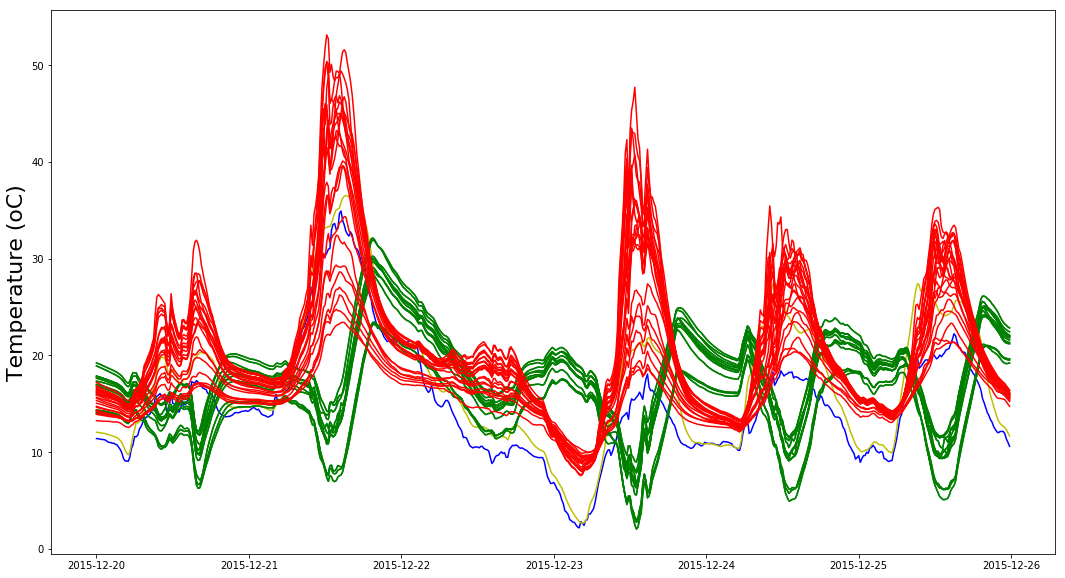

In [233]:
Start = '2015-12-20'
End ='2015-12-25'
figure = plt.figure(figsize=(18,10))
plt.plot(Data.AirTemperature.loc[Start:End], color = 'b')
plt.plot(Data.PannelTemperature.loc[Start:End], color = 'y')
plt.plot(Data.SoilTemp15cm.loc[Start:End], color = 'g')
plt.plot(Data.SoilTemp15cm.loc[Start:End], color = 'g')
plt.plot(Data.SurfaceSoilTemp.loc[Start:End], color = 'r')
plt.ylabel('Temperature (oC)',fontsize=22)
#plt.plot(TopTempDF.loc[Start:End], color = 'k')

# Averaging thermocouple data is shit.  Use temp from cs650 instead

# Get the soil temperatue data for the top 15cm 

In [234]:
TopTemp = SoilTempData.D1B + SoilTempData.D1I
TopTemp =  TopTemp /2
TopTemp = TopTemp + SoilTempData.D2
TopTemp = TopTemp /2

TopTempDF = pd.concat([TopTemp],axis=1,keys=['TopTemp'],names=['Measurement'])

Graph = plt.figure(figsize=(18,60))
ax = Graph.add_subplot(8,1,1)
GH.AddIndexedPlot(TopTempDF.TopTemp,ax,GPs,2)
ax = Graph.add_subplot(8,1,2)
GH.AddIndexedPlot(TopTempDF.TopTemp.loc[Start:End,:],ax,GPs,2)

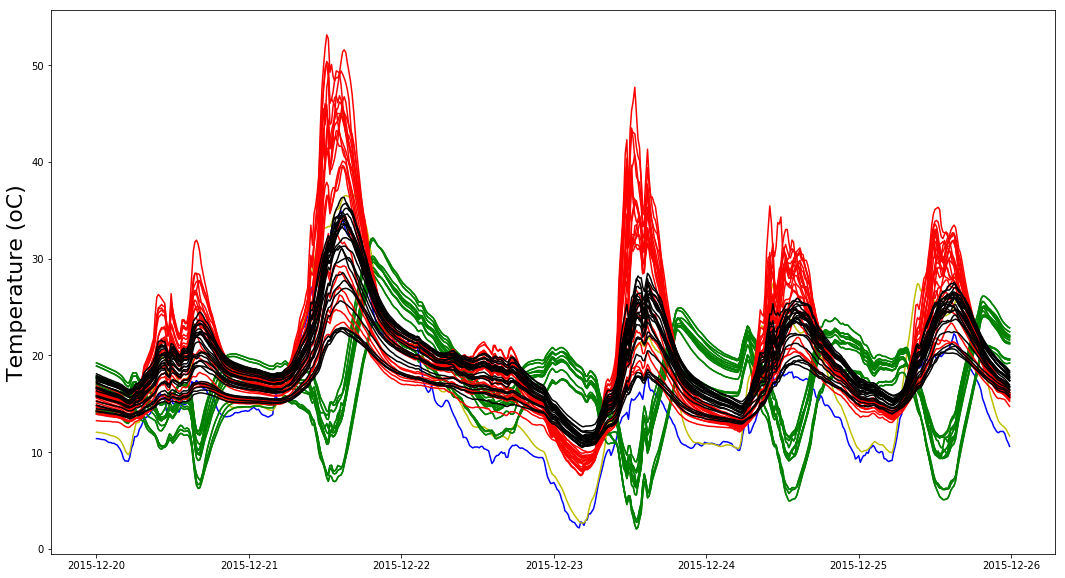

In [235]:
figure = plt.figure(figsize=(18,10))
plt.plot(Data.AirTemperature.loc[Start:End], color = 'b')
plt.plot(Data.PannelTemperature.loc[Start:End], color = 'y')
plt.plot(Data.SoilTemp15cm.loc[Start:End], color = 'g')
plt.plot(Data.SoilTemp15cm.loc[Start:End], color = 'g')
plt.plot(Data.SurfaceSoilTemp.loc[Start:End], color = 'r')
plt.ylabel('Temperature (oC)',fontsize=22)
plt.plot(TopTempDF.loc[Start:End], color = 'k')

# The CS650 data is better so use that.

# Bring in the soil water data for the top layer

Text(0,0.5,'Volumetric Water Content (mm/mm)')

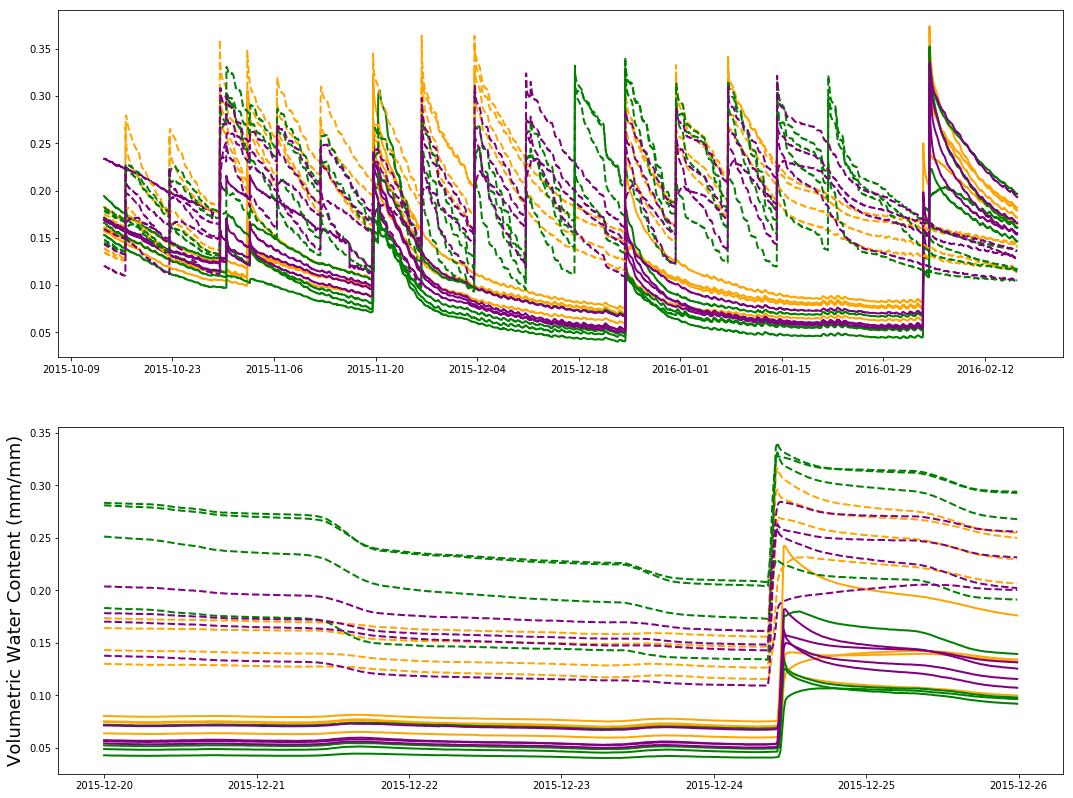

In [236]:
TopWater = np.add(SoilWaterData.loc[:,'D1B'],SoilWaterData.loc[:,'D1I'])
TopWater /=2
TopWater *= 1/BD

TopWaterDF = pd.concat([TopWater],axis=1,keys=['TopWater'],names=['Measurement'])

Graph = plt.figure(figsize=(18,60))
ax = Graph.add_subplot(8,1,1)
GH.AddIndexedPlot(TopWaterDF.TopWater,ax,GPs,2)
ax = Graph.add_subplot(8,1,2)
GH.AddIndexedPlot(TopWaterDF.TopWater.loc[Start:End,:],ax,GPs,2)

plt.ylabel('Volumetric Water Content (mm/mm)',fontsize=18)
plt.ylabel('Volumetric Water Content (mm/mm)',fontsize=18)

# Calculate the specific heat capacity of soils

Text(0,0.5,'Soil Heat capacity (J/oc/kg)')

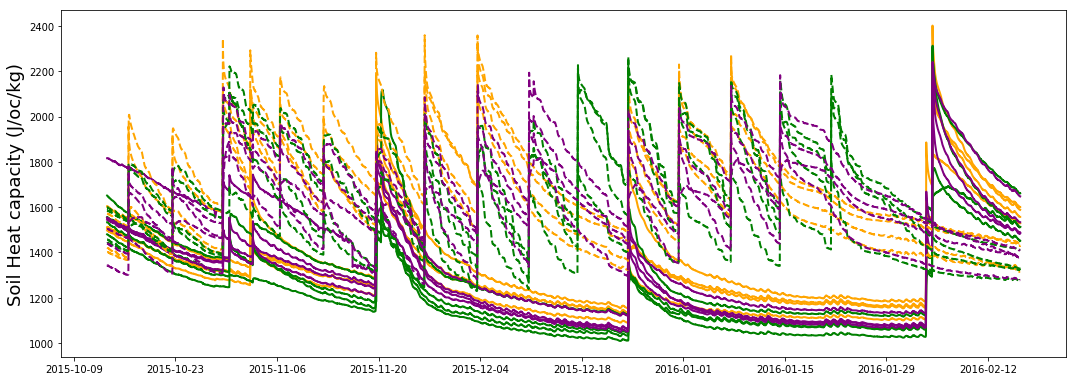

In [237]:
Cw = np.multiply(TopWater,CW)
Cs = np.add(Cw,CD)

CsDF = pd.concat([Cs],axis=1,keys=['Cs'],names=['Measurement'])

Graph = plt.figure(figsize=(18,60))
ax = Graph.add_subplot(8,1,1)
GH.AddIndexedPlot(CsDF.Cs,ax,GPs,2)

plt.ylabel('Soil Heat capacity (J/oc/kg)',fontsize=18)

## Calculate temperature deltas

Text(0,0.5,'Temperature Delta(oC)')

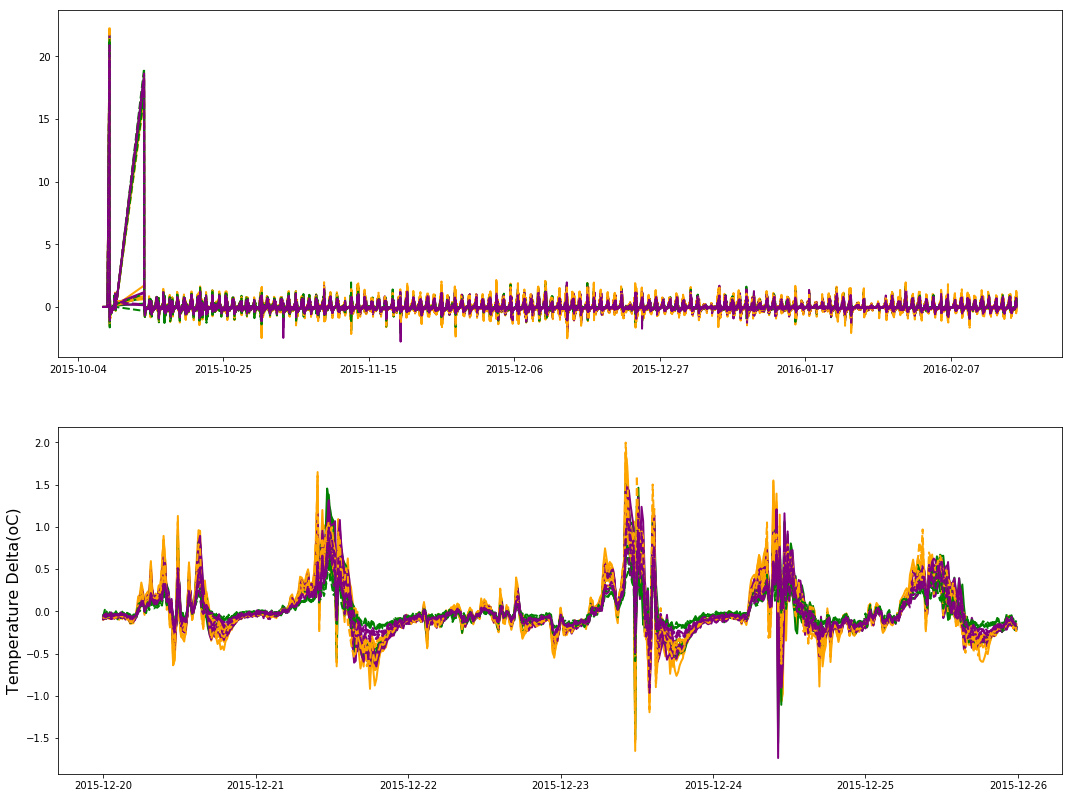

In [238]:
DeltaTemp = TopTempDF.diff()

Graph = plt.figure(figsize=(18,60))
ax = Graph.add_subplot(8,1,1)
GH.AddIndexedPlot(DeltaTemp.TopTemp,ax,GPs,2)
ax = Graph.add_subplot(8,1,2)
GH.AddIndexedPlot(DeltaTemp.TopTemp.loc[Start:End,:],ax,GPs,2)

plt.ylabel('Temperature Delta(oC)',fontsize=16)

# Calculate energy stored in soil above heat flux plates

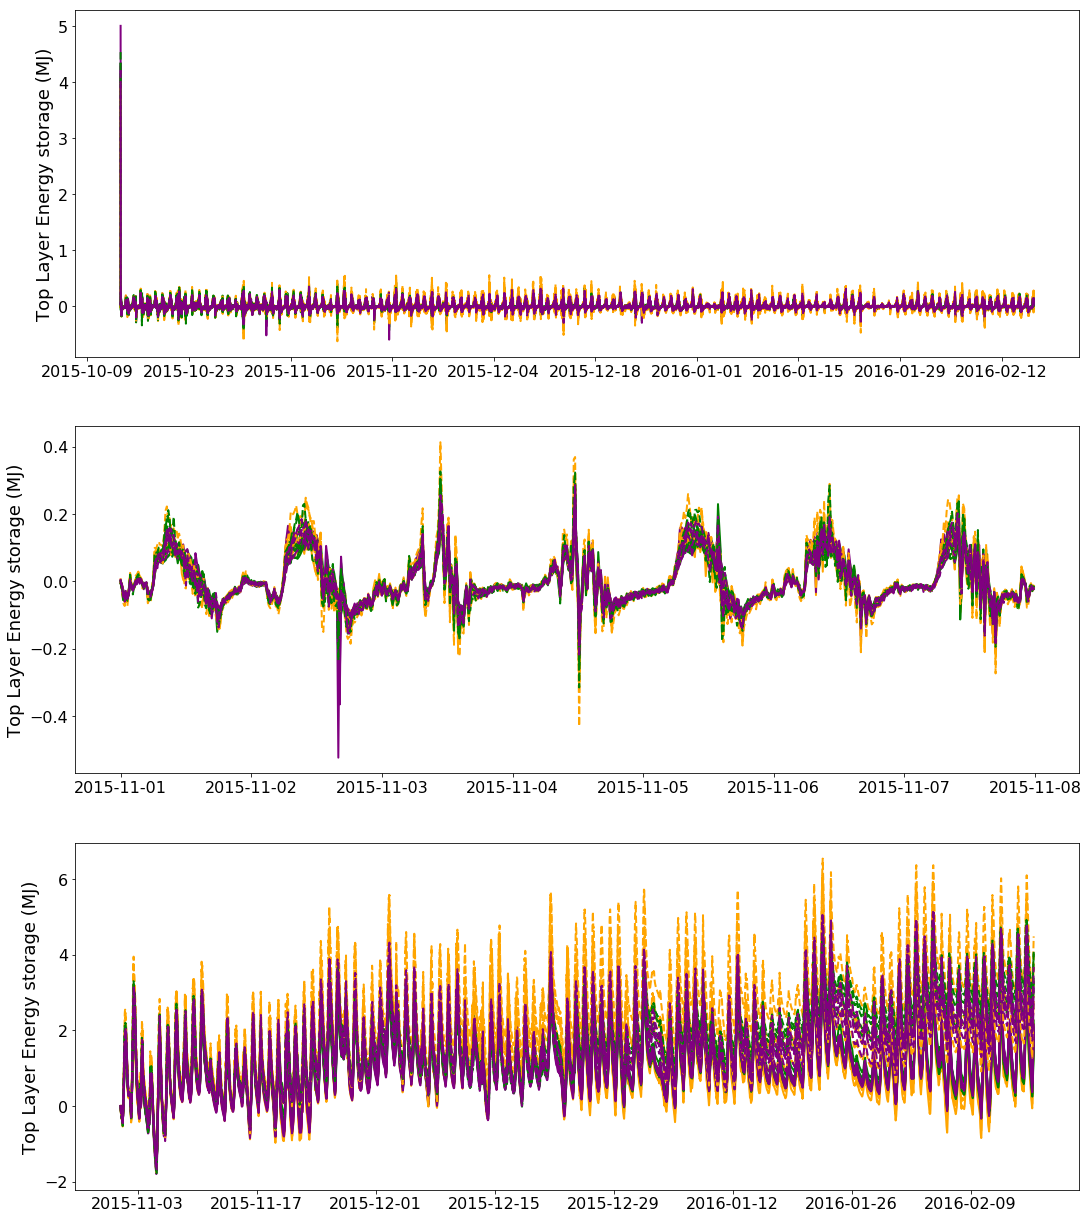

In [239]:
#Calculate the joules of energy stored in the soil per kg of soil
EnergyStored = np.multiply(DeltaTemp.TopTemp, CsDF.Cs.reindex(DeltaTemp.index)) 
#Adjust for soil depth to give joules in the top 150 mm
EnergyStored = np.multiply(EnergyStored,150)
#Convert to MJ
EnergyStored = np.divide(EnergyStored,1000000)

# tup = ['S']
# NewIndex = pd.MultiIndex.from_product([tup,Cultivars,Irrigations,[1,2,3,4]],names=['Measurement','Cultivar','Irrigation',''])
# TopEnergy = pd.DataFrame(data = EnergyStored, index = SoilWaterData.index, columns = NewIndex)


TopEnergy = pd.concat([EnergyStored],axis=1,keys=['S'],names=['Measurement'])

Graph = plt.figure(figsize=(18,60))
ax = Graph.add_subplot(8,1,1)
GH.AddIndexedPlot(TopEnergy.S,ax,GPs,2)
plt.ylabel('Top Layer Energy storage (MJ)',fontsize=18)
plt.tick_params(labelsize=16)

ax = Graph.add_subplot(8,1,2)
GH.AddIndexedPlot(TopEnergy.loc['2015-11-1':'2015-11-07','S'],ax,GPs,2)
plt.ylabel('Top Layer Energy storage (MJ)',fontsize=18)
plt.tick_params(labelsize=16)

ax = Graph.add_subplot(8,1,3)
GH.AddIndexedPlot(TopEnergy.loc['2015-11-1':,'S'].cumsum(),ax,GPs,2)
plt.ylabel('Top Layer Energy storage (MJ)',fontsize=18)
plt.tick_params(labelsize=16)

# Convert instantatious heat flux to Accumulated energy (W - MJ)

In [240]:
#Multiply by the duration of the measurement period to go from W/m2 to J/m2
HeatFluxMJ = np.multiply(Data.HeatFlux.reindex(TopEnergy.index),900)
#divide by a million to conver to JM
HeatFluxMJ = np.divide(HeatFluxMJ,1000000)

Graph = plt.figure(figsize=(18,60))
ax = Graph.add_subplot(8,1,1)
GH.AddIndexedPlot(HeatFluxMJ,ax,GPs,2)
plt.ylabel('Deep Soil Heat Flux (MJ)',fontsize=18)
plt.tick_params(labelsize=16)

ax = Graph.add_subplot(8,1,2)
GH.AddIndexedPlot(HeatFluxMJ.loc['2015-11-1':'2015-11-07',:],ax,GPs,2)
plt.ylabel('Deep Soil Heat Flux (MJ)',fontsize=18)
plt.tick_params(labelsize=16)

ax = Graph.add_subplot(8,1,3)
GH.AddIndexedPlot(HeatFluxMJ.loc['2015-11-1':,:].cumsum(),ax,GPs,2)
plt.ylabel('Deep Soil Heat Flux (MJ)',fontsize=18)
plt.tick_params(labelsize=16)

# Add the two heat fluxes together to give total heat flux to the soil

In [241]:
DaylightIndex = Data.IncomingRadnMJ.where(Data.IncomingRadnMJ>0.002)
DaylightIndex.dropna(inplace=True)
DaylightIndex = DaylightIndex.index.tolist()

In [242]:
#Add total energy fluxes together
SoilHeatFluxMJ = np.add(HeatFluxMJ,TopEnergy.S.reindex(columns=HeatFluxMJ.columns.tolist()))
#Divide by the duration of the measurement period to make instanious (MJ/m2 to MW/m2)
SoilHeatFluxMW = np.divide(SoilHeatFluxMJ,900)
#Multiply by a million to go from MW/m2 to W/m2
SoilHeatFluxW = np.multiply(SoilHeatFluxMW,1000000)

Graph = plt.figure(figsize=(18,60))
ax = Graph.add_subplot(8,1,1)
GH.AddIndexedPlot(SoilHeatFluxW.reindex(labels=DaylightIndex),ax,GPs,2)
plt.ylabel('Deep Soil Heat Flux (MJ)',fontsize=18)
plt.tick_params(labelsize=16)

ax = Graph.add_subplot(8,1,2)
GH.AddIndexedPlot(SoilHeatFluxW.reindex(labels=DaylightIndex).loc['2015-12-1':'2015-12-7'],ax,GPs,2)
plt.ylabel('Deep Soil Heat Flux (MJ)',fontsize=18)
plt.tick_params(labelsize=16)

ax = Graph.add_subplot(8,1,3)
GH.AddIndexedPlot(SoilHeatFluxW.cumsum(),ax,GPs,2)
plt.ylabel('Deep Soil Heat Flux (MJ)',fontsize=18)
plt.tick_params(labelsize=16)

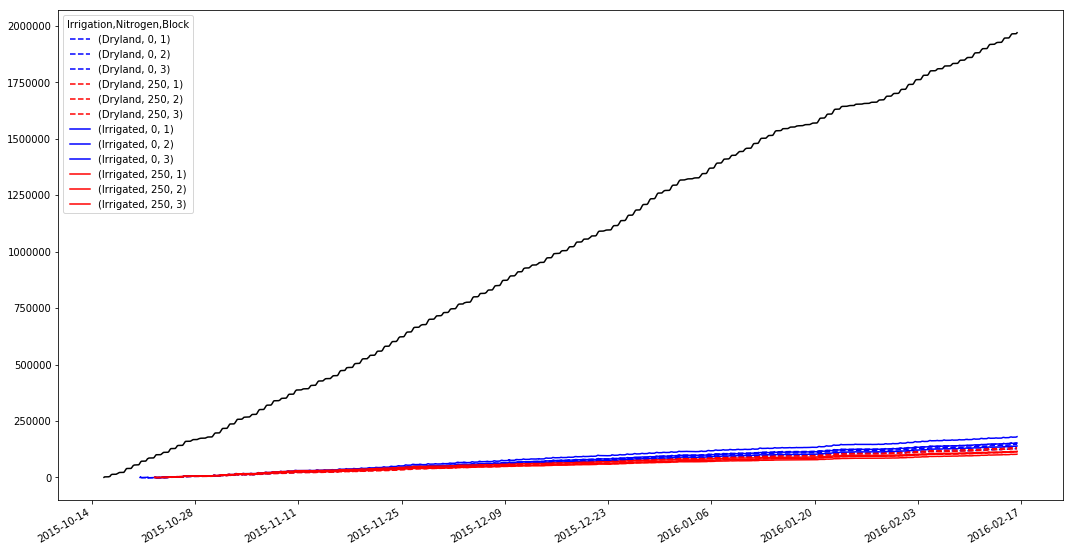

In [243]:
Styles = ['b--','b--','b--','r--','r--','r--',
          'b-','b-','b-','r-','r-','r-']
SoilHeatFluxW.reindex(DaylightIndex).cumsum().plot(figsize=(18,10),style=Styles)
#Plot incoming net radiation (taking total radiation, converting to W and multiplying by 0.66 to give net radn)
plt.plot(Data.IncomingRadnKW.reindex(DaylightIndex).index,Data.IncomingRadnKW.loc[DaylightIndex].multiply(1000*0.66).cumsum(),'-',color='k',label='Incomming Radn')

# Relative to incoming energy, Soil heat flux is quite small over the duration of the experiment

In [244]:
SoilHeatFluxW.index.name = 'Date'
SoilHeatFluxWLong = SoilHeatFluxW.resample('h').mean().unstack()
SoilHeatFluxWLong.name = 'G'
SoilHeatFluxWLong.to_pickle('.\DataFrames\HourlySoilHeatFluxTotalW.pkl')

NightIndex = SoilHeatFluxW.index.indexer_between_time(datetime.time(23),
                    datetime.time(4))
SoilHeatFluxW.iloc[NightIndex,:].resample('h').mean().to_pickle('.\DataFrames\HourlySoilHeatFluxDarkW.pkl')
SoilHeatFluxMJ.iloc[NightIndex,:].resample('h').sum().to_pickle('.\DataFrames\HourlySoilHeatFluxDarkMJ.pkl')
SoilHeatFluxMJ.iloc[NightIndex,:].resample('h').sum().divide(2.4).to_pickle('.\DataFrames\HourlySoilHeatFluxDark_mm.pkl')

In [245]:
SoilHeatFluxMJ.index.name='Date'
SoilHeatFluxMJLong = SoilHeatFluxMJ.resample('h').sum().unstack()
SoilHeatFluxMJLong.name = 'G'
SoilHeatFluxMJLong.to_pickle('.\DataFrames\HourlySoilHeatFluxTotalMJ.pkl')

# Look at soil heaf flux relative to incomming radiation

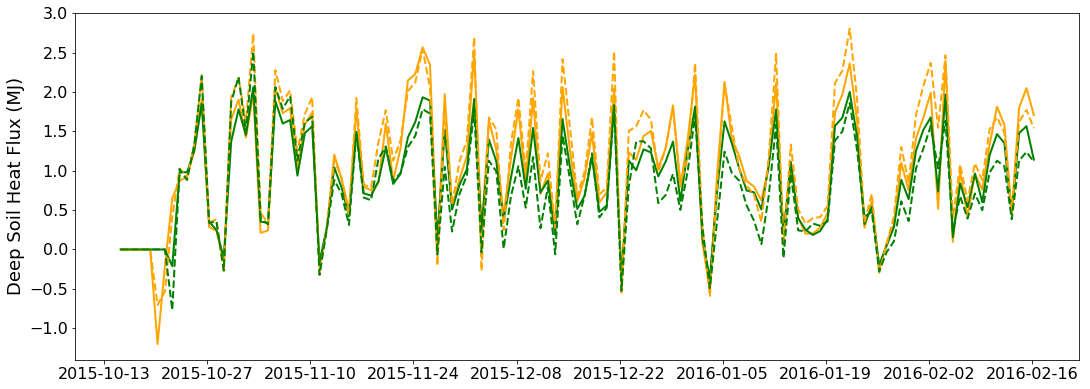

In [246]:
SoilHeatFluxMJMeans = SoilHeatFluxMJ.groupby(level=['Irrigation','Nitrogen'],axis=1).mean()
SoilHeatFluxMJDaylightMeans = SoilHeatFluxMJMeans.reindex(DaylightIndex).resample('24h',base=6).sum()

GDayDF = pd.concat([SoilHeatFluxMJDaylightMeans],axis=1,keys=['GDay'],names=['Measurement'])

Graph = plt.figure(figsize=(18,60))
ax = Graph.add_subplot(8,1,1)
GH.AddIndexedPlot(GDayDF.GDay,ax,GPs,2)
plt.ylabel('Deep Soil Heat Flux (MJ)',fontsize=18)
plt.tick_params(labelsize=16)


### Bring in radiation interception data

In [247]:
CoverData = pd.read_pickle('.\DataFrames\DailyFPARTot.pkl')
CoverDataMeans = CoverData.groupby(level=('Irrigation','Nitrogen'),axis=1).mean()
LongCoverData = CoverDataMeans.unstack(0)
OffSetTimeIndex = pd.MultiIndex.from_arrays([LongCoverData.index.get_level_values(0),
                           LongCoverData.index.get_level_values(1),
                           LongCoverData.index.get_level_values(2) + datetime.timedelta(hours=6)],
                         names=LongCoverData.index.names)
LongCoverData.index = OffSetTimeIndex

(array([735884., 735898., 735912., 735926., 735940., 735954., 735968.,
        735982., 735996., 736010.]), <a list of 10 Text xticklabel objects>)

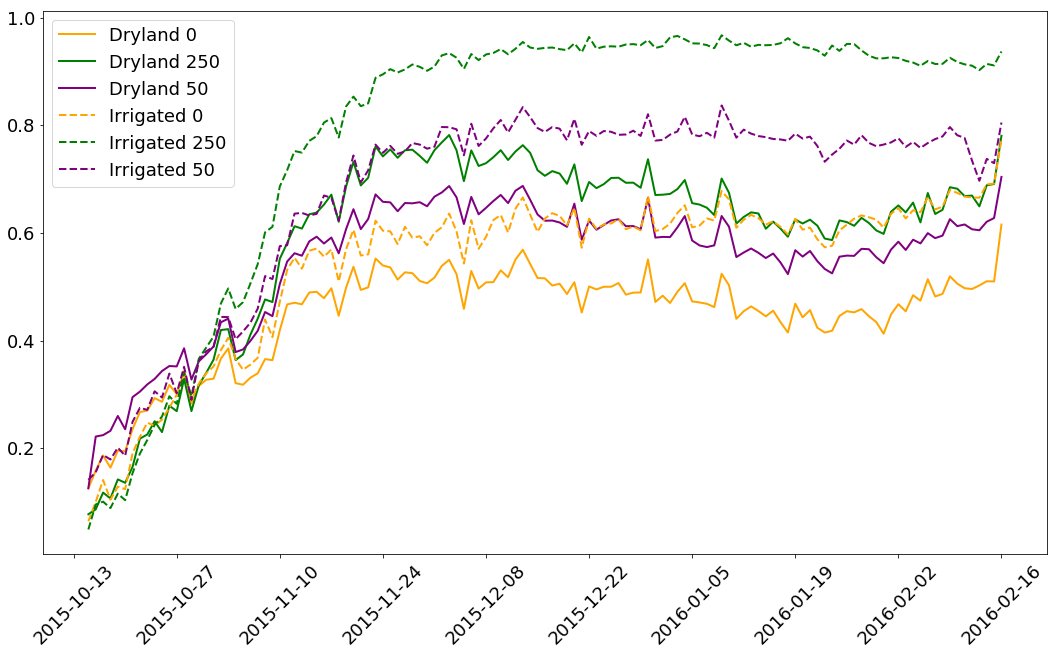

In [248]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(CoverDataMeans,ax,GPs,2)
plt.legend(fontsize=18)
plt.tick_params(labelsize=18)
plt.xticks(rotation=45)

## Make a data frame for comparing GRn with other variables

In [249]:
def SliceFullPlots(CompleteData,NewIndex):
    DayTimeData = CompleteData.reindex(DaylightIndex)
    Means = DayTimeData.groupby(level=('Irrigation','Nitrogen'), axis=1).mean()
    DailyMeans = Means.resample('24h',base=6).mean()
    Long = DailyMeans.unstack(0)
    return Long.reindex(NewIndex)

In [250]:
LongG = GDayDF.loc[:,('GDay')].unstack(0)
LongData = pd.DataFrame(LongG, columns = ['GDay'])
for irr in ['Dryland','Irrigated']:
    for nit in ['0','250']:
        LongData.loc[(irr,nit),'AirTemperature'] = Data.loc[DaylightIndex,'AirTemperature'].resample('24h',base=6).mean().values
        LongData.loc[(irr,nit),'RelativeHumidity'] = Data.loc[DaylightIndex,'RelativeHumidity'].resample('24h',base=6).mean().values
        LongData.loc[(irr,nit),'Windspeed'] = Data.loc[DaylightIndex,'Windspeed'].resample('24h',base=6).mean().values
        LongData.loc[(irr,nit),'IncomingRadnMJ'] = Data.loc[DaylightIndex,'IncomingRadnMJ'].resample('24h',base=6).sum().values

LongData.loc[:,'fPAR'] = LongCoverData.reindex(LongData.index)
LongData.loc[:,'SurfaceSoilTemp'] = SliceFullPlots(Data.SurfaceSoilTemp,LongData.index)
LongData.loc[:,'TempAirSoil1Diff'] = LongData.loc[:,'AirTemperature'] - SliceFullPlots(Data.SurfaceSoilTemp,LongData.index) 
LongData.loc[:,'SoilTemp15'] = SliceFullPlots(TopTempDF.TopTemp,LongData.index)
LongData.loc[:,'TempAirSoil15Diff'] = LongData.loc[:,'AirTemperature'] - LongData.loc[:,'SoilTemp15']
LongData.loc[:,'SoilWater'] = SliceFullPlots(TopWaterDF.TopWater,LongData.index)
LongData.loc[:,'SoilRad'] = LongData.loc[:,'IncomingRadnMJ']* (1-LongData.loc[:,'fPAR'])
LongData.dropna(inplace=True)

## Look at heat flux against different variables

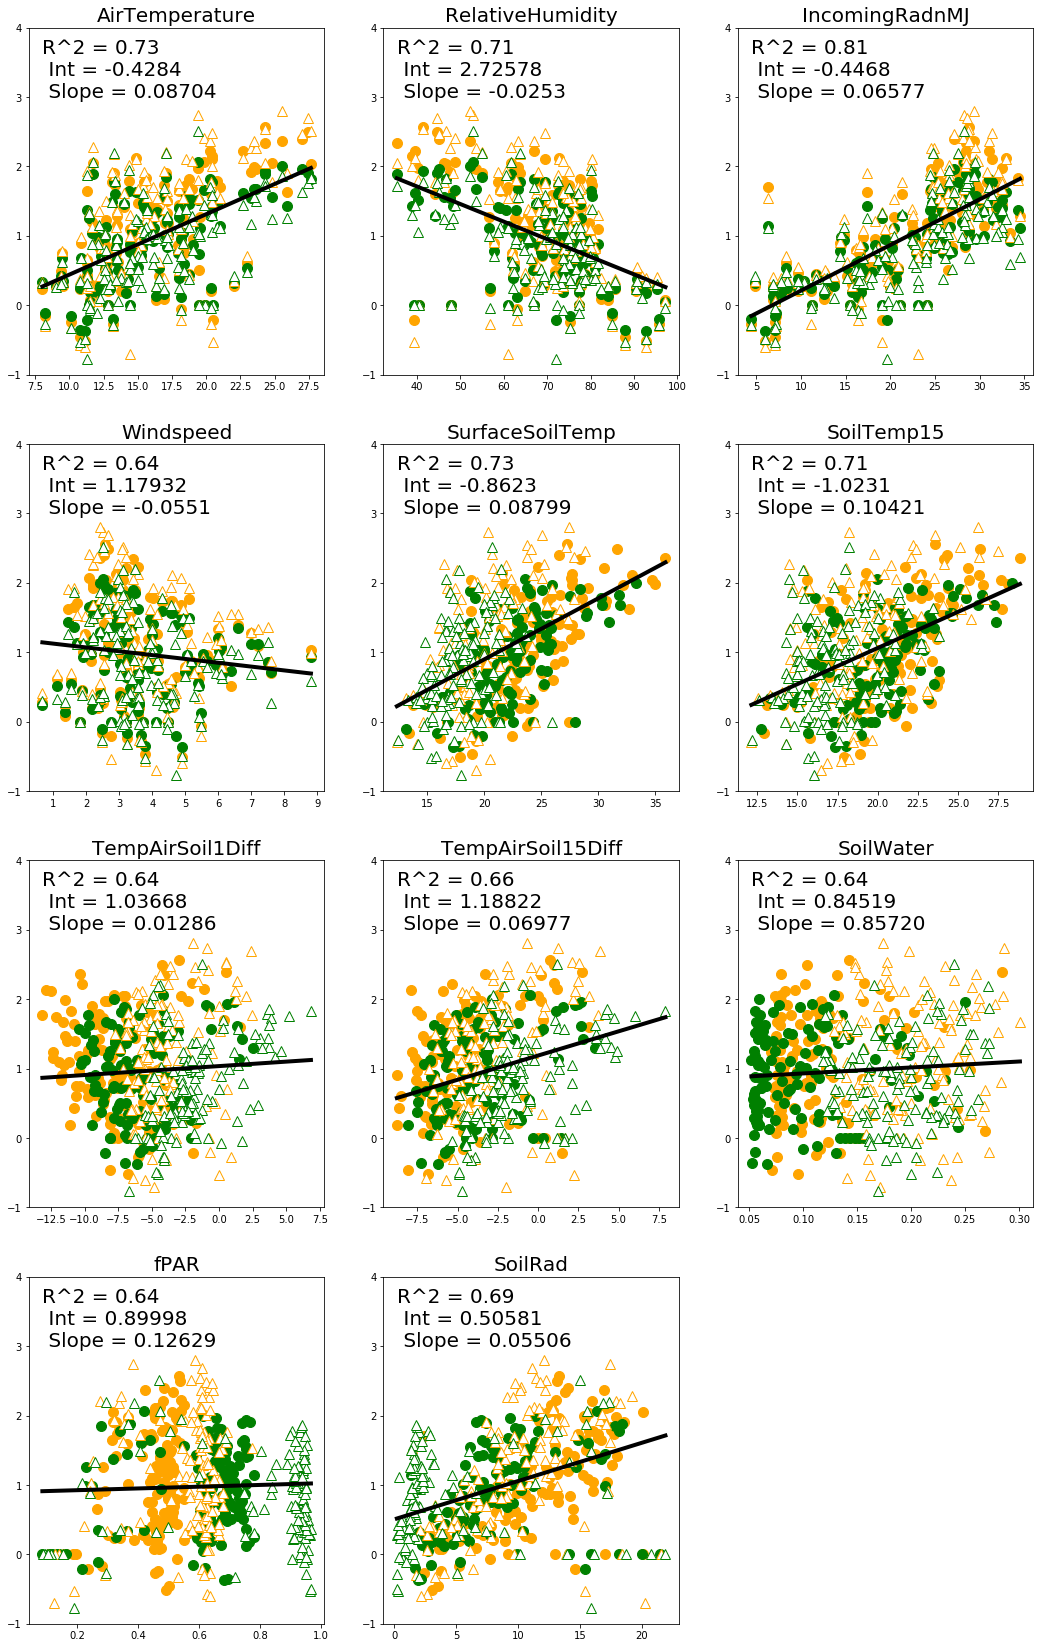

<Figure size 1296x720 with 0 Axes>

In [252]:
Graph = plt.figure(figsize=(18,60))
start = '2014-12-10'
end = '2015-02-10'
plt.figure(figsize=(18,10))
ecols = ['b','r','b','r']
fcols = ['w','w','b','r']
Irrigations = ['High','Low']
pannel = 1
Descriptors = ['AirTemperature','RelativeHumidity','IncomingRadnMJ',
               'Windspeed','SurfaceSoilTemp','SoilTemp15','TempAirSoil1Diff',
               'TempAirSoil15Diff','SoilWater','fPAR','SoilRad']
for des in Descriptors:
    DailyDescriptor = LongData.loc[:,des]
    ax = Graph.add_subplot(8,3,pannel)
    GH.AddIndexedXY(LongData[des].unstack(['Irrigation','Nitrogen']),
                    LongData['GDay'].unstack(['Irrigation','Nitrogen']),
                    ax,GPs,10)
    
    X = LongData.loc[:,LongData.columns.isin([des])]
    Y = LongData.loc[:,'GDay']
    ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                            sm.add_constant(X), # X variable
                                            missing='drop',                                     # ignor and data where one value is missing
                                            hasconst=False) 
    Regres = ModTemp.fit(); 
    Xs = []
    Xs.append(X.min())
    Xs.append(X.max())
    Ys = []
    Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
    Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
    ax.plot(Xs,Ys,'-', linewidth = 4, color='k')
    fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
    ax.text(X.min(),3,fitR2,fontsize=20)
    ax.set_ylim(-1,4)
    ax.set_title(des, fontsize = 20)
    pannel +=1

## The best descriprors are fPAR, AirTemp and Humidity

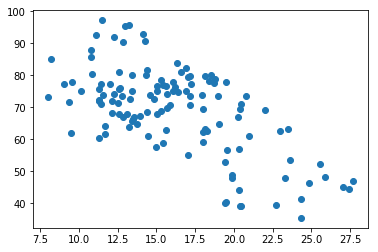

In [253]:
plt.plot(LongData.loc[(irr,nit),'AirTemperature'],
        LongData.loc[(irr,nit),'RelativeHumidity'],'o')

In [254]:
X = LongData.loc[(irr,nit),'AirTemperature']
Y = LongData.loc[(irr,nit),'RelativeHumidity']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       RelativeHumidity   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2752.
Date:                Tue, 16 Oct 2018   Prob (F-statistic):          3.23e-102
Time:                        14:20:36   Log-Likelihood:                -465.91
No. Observations:                 124   AIC:                             935.8
Df Residuals:                     122   BIC:                             941.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            100.3256      3.591     27.934      0.000      93.216     107.435
AirTemperature    -1.9361      0.215     -9.008      0.000      -2.362      -1.511
==============================================================================
Omnibus:                        3.808   Durbin-Watson:                   0.712
Prob(Omnibus):                  0.149   Jarque-Bera (JB):                2.266
Skew:                          -0.071   Prob(JB):                        0.322
Kurtosis:                       2.353   Cond. No.                         64.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Air temperature and relative humidity are highly correlated so lets forget about humidity as air temperature is easier to deal with in a practical situation

## How much of the variation can AirTemp and fPAR account for on their own.

In [255]:
Descriptors = ['AirTemperature','RelativeHumidity','IncomingRadnMJ','Windspeed',
              'SurfaceSoilTemp','SoilTemp15','TempAirSoil1Diff',
               'TempAirSoil15Diff','SoilWater','fPAR','SoilRad']
X = LongData.loc[:,LongData.columns.isin(Descriptors)]
Y = LongData.loc[:,'GDay']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GDay   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     382.2
Date:                Tue, 16 Oct 2018   Prob (F-statistic):          4.89e-223
Time:                        14:20:36   Log-Likelihood:                -260.61
No. Observations:                 496   AIC:                             541.2
Df Residuals:                     486   BIC:                             583.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.0800      0.271     -7.665      0.000      -2.613      -1.547
AirTemperature        0.0329      0.004      9.275      0.000       0.026       0.040
RelativeHumidity      0.0098      0.003      3.629      0.000       0.004       0.015
Windspeed            -0.1268      0.015     -8.733      0.000      -0.155      -0.098
IncomingRadnMJ        0.0491      0.005      9.209      0.000       0.039       0.060
fPAR                  0.7961      0.263      3.022      0.003       0.279       1.314
SurfaceSoilTemp      -0.0031      0.011     -0.280      0.780      -0.025       0.019
TempAirSoil1Diff      0.0360      0.012      3.093      0.002       0.013       0.059
SoilTemp15            0.0254      0.014      1.832      0.068      -0.002       0.053
TempAirSoil15Diff     0.0075      0.014      0.519      0.604      -0.021       0.036
SoilWater            -0.1368      0.452     -0.303      0.762      -1.025       0.752
SoilRad               0.0671      0.013      5.240      0.000       0.042       0.092
==============================================================================
Omnibus:                      149.833   Durbin-Watson:                   1.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              593.284
Skew:                          -1.318   Prob(JB):                    1.48e-129
Kurtosis:                       7.665   Cond. No.                     1.66e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.17e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [256]:
Descriptors = ['AirTemperature',
               'IncomingRadnMJ',
               'fPAR']
X = LongData.loc[:,LongData.columns.isin(Descriptors)]
Y = LongData.loc[:,'GDay']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GDay   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     763.9
Date:                Tue, 16 Oct 2018   Prob (F-statistic):          1.84e-209
Time:                        14:20:36   Log-Likelihood:                -311.82
No. Observations:                 496   AIC:                             631.6
Df Residuals:                     492   BIC:                             648.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.0198      0.095    -10.755      0.000      -1.206      -0.834
AirTemperature     0.0603      0.005     12.048      0.000       0.050       0.070
IncomingRadnMJ     0.0567      0.003     20.721      0.000       0.051       0.062
fPAR              -0.3395      0.097     -3.506      0.000      -0.530      -0.149
==============================================================================
Omnibus:                       86.491   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              235.282
Skew:                          -0.851   Prob(JB):                     8.11e-52
Kurtosis:                       5.914   Cond. No.                         157.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [257]:
Descriptors = ['AirTemperature',
               'SoilRad']
X = LongData.loc[:,LongData.columns.isin(Descriptors)]
Y = LongData.loc[:,'GDay']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GDay   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     643.1
Date:                Tue, 16 Oct 2018   Prob (F-statistic):          5.86e-170
Time:                        14:20:36   Log-Likelihood:                -406.94
No. Observations:                 496   AIC:                             819.9
Df Residuals:                     493   BIC:                             832.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.8997      0.103     -8.759      0.000      -1.102      -0.698
AirTemperature     0.0871      0.006     15.363      0.000       0.076       0.098
SoilRad            0.0551      0.005     11.874      0.000       0.046       0.064
==============================================================================
Omnibus:                      141.565   Durbin-Watson:                   1.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              389.741
Skew:                          -1.385   Prob(JB):                     2.34e-85
Kurtosis:                       6.344   Cond. No.                         78.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## R^2 of 0.93 with Radiation and fPAR and AirTemp and 0.931 with all others included.  No need to include the others!!!

In [258]:
# def estGDay(Radn, fPAR, AirTemp):
#     Const = 0.6306 
#     RadEff = np.multiply(Radn.values,0.0906)
#     fPAREff = np.multiply(fPAR, -1.733)
#     AirTempEff = np.multiply(AirTemp.values,0.0556)
#     return Const + RadEff + fPAREff + AirTempEff 
def estGDay(SoilRadn, AirTemp):
    Const = -0.7091
    SoilRadEff = np.multiply(SoilRadn.values,0.2149)
    AirTempEff = np.multiply(AirTemp.values,0.0736)
    return Const + SoilRadEff  + AirTempEff 

In [259]:
LongData.loc[:,'EstGDayMJ'] = estGDay(LongData.loc[:,'SoilRad'],
                                     LongData.loc[:,'AirTemperature'])

In [260]:
for cul in Cultivars:
    for irr in Irrigations:
        Obs = LongData.loc[(cul,irr),'GDay']
        Pred = LongData.loc[(cul,irr),'EstGDayMJ']
        plt.plot(Pred,Obs,'o')

X = LongData.loc[:,'EstGDayMJ']
Y = LongData.loc[:,'GDay']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
plt.plot(Xs,Ys,'-', linewidth = 4, color='k')
fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
plt.text(X.min(),2.,fitR2,fontsize=20)        


NameError: name 'Cultivars' is not defined

## Day time Soil heat flux can be modeled as 
GDay = 0.6306 + IncommingRadn * 0.0906 + fPAR * -1.733 + AirT * 0.0556

## Now we can estimate day time soil heat flux for all plots

In [ ]:
DailyFPAR = pd.read_pickle('.\DataFrames\DailyFPAREstInt.pkl')

In [ ]:
DailyFPAR.plot(legend=False,figsize=(18,10))

In [ ]:
DayGEst = pd.DataFrame(index = DailyFPAR.index, columns = DailyFPAR.columns)
Radn = Data.loc[DaylightIndex,'IncomingRadnMJ'].resample('24h',base=6).sum()
Radn.index = Radn.index.normalize()
Temp = Data.loc[DaylightIndex, 'AirTemperature'].resample('24h', base=6).mean()
Temp.index = Temp.index.normalize()
for plot in DayGEst:
    DayGEst.loc[:,plot] = estGDay((1-DailyFPAR.loc[:,plot]) * Radn.loc[DailyFPAR.index,('Expt','Expt')],
                                 Temp.loc[DailyFPAR.index,('Expt','Expt')])

In [ ]:
DayGEst.index.name='Date'

In [ ]:
DayGEst.plot(figsize=(18,10), legend = False)

In [ ]:
DayGEst.to_pickle('.\DataFrames\SoilHeatFluxDayEst.pkl')

## Have a look at Dark heat flux

In [ ]:
DarkIndex = Data.IncomingRadnMJ.where(Data.IncomingRadnMJ<0.002)
DarkIndex.dropna(inplace=True)
DarkIndex = DarkIndex.index.tolist()

In [ ]:
SoilHeatFluxMJNightMeans = SoilHeatFluxMJMeans.loc[DarkIndex,:].resample('24h',base=6).sum()
SoilHeatFluxMJNightMeans.index = SoilHeatFluxMJNightMeans.index.normalize()

GNight = SoilHeatFluxMJNightMeans.values

tup = ['GNight']
reps = [1,2,3]
NewIndex = pd.MultiIndex.from_product([tup,Cultivars,Irrigs],names=['Measurement','Cultivar','Irrigation'])
GNightDF = pd.DataFrame(data = GNight, index = IncommingRadnDaylight.index, columns = NewIndex)
GNightDF.loc[pd.to_datetime(['2014-12-26 00:00:00',
                           '2014-12-27 00:00:00',
                           '2014-12-28 00:00:00',
                           '2015-02-12 00:00:00',
                           '2015-02-13 00:00:00',
                            '2015-02-14 00:00:00',
                            '2015-02-15 00:00:00',
                            '2015-02-16 00:00:00',
                            '2015-02-17 00:00:00',
                            '2015-02-18 00:00:00',
                            '2015-02-19 00:00:00',
                            '2015-02-20 00:00:00',
                            '2015-02-21 00:00:00',
                            '2015-02-22 00:00:00',
                            '2015-02-23 00:00:00',
                            '2015-02-24 00:00:00']),:] = np.nan
GNightDF.loc['2014-11-07':].plot(figsize=(18,10),style=['b--','r--','b-','r-'],)
GNightDF.loc['2014-12-1':'2014-12-7'].groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(figsize=(18,10),style=['b--','r--','b-','r-'])

In [ ]:
def SliceFullPlotsDark(CompleteData,Variable):
    Chunk = CompleteData.loc[:,Variable]
    NewIndex = pd.MultiIndex.from_product([Cultivars,['Low','Mid','High'],[1,2,3,4]],names=['Cultivar','Irrigation',''])
    Chunk.columns = NewIndex
    SubIndex = pd.MultiIndex.from_product([Cultivars,['Low','High'],[1,3,4]],names=['Cultivar','Irrigation',''])
    SubChunk = Chunk.loc[DarkIndex,SubIndex]
    SubChunkGroup = SubChunk.groupby(level=('Cultivar','Irrigation'), axis=1).mean()
    SubChunkAgregate = SubChunkGroup.resample('24h',base=6).mean()
    SubChunkAgregate.index = SubChunkAgregate.index.normalize()
    SubChunkUnstack = SubChunkAgregate.unstack()
    return SubChunkUnstack
    

In [ ]:
LongG = GNightDF.loc[:,('GNight')].unstack(0)
LongDataDark = pd.DataFrame(LongG, columns = ['GDark'])
for cul in Cultivars:
    for irr in IrrigationsShort:
        LongDataDark.loc[(cul,irr),'AirTemperature'] = Data.loc[DarkIndex,'AirTemperature'].resample('24h',base=6).mean().values
        LongDataDark.loc[(cul,irr),'RelativeHumidity'] = Data.loc[DarkIndex,'RelativeHumidity'].resample('24h',base=6).mean().values
        LongDataDark.loc[(cul,irr),'Windspeed'] = Data.loc[DarkIndex,'Windspeed'].resample('24h',base=6).mean().values
        LongDataDark.loc[(cul,irr),'IncomingRadnMJ'] = Data.loc[DarkIndex,'IncomingRadnMJ'].resample('24h',base=6).sum().values

LongDataDark.loc[:,'fPAR'] = CoverData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().unstack()
LongDataDark.loc[:,'SurfaceSoilTemp'] = SliceFullPlots(Data,'SurfaceSoilTemp')
LongDataDark.loc[:,'TempAirSoil1Diff'] = LongDataDark.loc[:,'AirTemperature'] - SliceFullPlots(Data,'SurfaceSoilTemp') 
SubIndex = pd.MultiIndex.from_product([['TopTemp'],Cultivars,['Low','High'],[1,3,4]],names=['Measurement','Cultivar','Irrigation',''])
Temp = TopTempDF.loc[DarkIndex,SubIndex].groupby(level=('Cultivar','Irrigation'),axis=1).mean().resample('24h',base=6).mean()
Temp.index = Temp.index.normalize()
LongDataDark.loc[:,'SoilTemp15'] = Temp.unstack()
LongDataDark.loc[:,'TempAirSoil15Diff'] = LongDataDark.loc[:,'AirTemperature'] - LongDataDark.loc[:,'SoilTemp15'] 
SubIndex = pd.MultiIndex.from_product([['TopWater'],Cultivars,['Low','High'],[1,3,4]],names=['Measurement','Cultivar','Irrigation',''])
Temp = TopWaterDF.loc[DarkIndex,SubIndex].groupby(level=('Cultivar','Irrigation'),axis=1).mean().resample('24h',base=6).mean()
Temp.index = Temp.index.normalize()
LongDataDark.loc[:,'SoilWater'] = Temp.unstack()


In [ ]:
Graph = plt.figure(figsize=(18,60))
start = '2014-12-10'
end = '2015-02-10'
plt.figure(figsize=(18,10))
ecols = ['b','r','b','r']
fcols = ['w','w','b','r']
Irrigations = ['High','Low']
pannel = 1
Descriptors = ['AirTemperature','RelativeHumidity',
               'Windspeed','SurfaceSoilTemp','SoilTemp15','TempAirSoil1Diff',
               'TempAirSoil15Diff','SoilWater','fPAR']
for des in Descriptors:
    DailyDescriptor = LongDataDark.loc[:,des]
    fig = Graph.add_subplot(8,3,pannel)
    pos = 0
    for cul in Cultivars:
        for irr in Irrigations:
            fig.plot(LongDataDark.loc[(cul,irr),des].loc['2014-11-07':],
                LongDataDark.loc[(cul,irr),'GDark'].loc['2014-11-07':],
                     'o',mec=ecols[pos],mfc=fcols[pos],mew = 3, markersize = 12,)
            pos+=1  
    
    X = LongDataDark.loc[:,LongDataDark.columns.isin([des])]
    Y = LongDataDark.loc[:,'GDark']
    ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                            sm.add_constant(X), # X variable
                                            missing='drop',                                     # ignor and data where one value is missing
                                            hasconst=False) 
    Regres = ModTemp.fit(); 
    Xs = []
    Xs.append(X.min())
    Xs.append(X.max())
    Ys = []
    Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
    Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
    fig.plot(Xs,Ys,'-', linewidth = 4, color='k')
    fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
    fig.text(X.min(),-0,fitR2,fontsize=20)
    fig.set_ylim(-2,0.5)
    fig.set_title(des, fontsize = 20)
    pannel +=1

In [ ]:
for cul in Cultivars:
    for irr in Irrigations:
        Day = LongData.loc[(cul,irr),'GDay']
        Night = LongDataDark.loc[(cul,irr),'GDark']
        plt.plot(Day,Night,'o')

X = LongData.loc[:,'GDay']
Y = LongDataDark.loc[:,'GDark']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
plt.plot(Xs,Ys,'-', linewidth = 4, color='k')
fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
plt.text(X.min(),2.,fitR2,fontsize=20)        


In [ ]:
Descriptors = ['AirTemperature','RelativeHumidity','IncomingRadnMJ','Windspeed',
              'SurfaceSoilTemp','SoilTemp15','TempAirSoil1Diff',
               'TempAirSoil15Diff','SoilWater','fPAR']
X = LongDataDark.loc[:,LongDataDark.columns.isin(Descriptors)]
Y = LongDataDark.loc[:,'GDark']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

In [ ]:
Descriptors = ['AirTemperature','fPAR']
X = LongDataDark.loc[:,LongDataDark.columns.isin(Descriptors)]
Y = LongDataDark.loc[:,'GDark']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

In [ ]:
def EstGDarkMJ(AirTemp,FPAR):
    Constant = -1.9157
    AirTempEff = np.multiply(AirTemp.values,0.0545)
    FPAREff = np.multiply(FPAR.values,0.666)  # 0.1% of the number of the beast   
    return Constant + AirTempEff + FPAREff

In [ ]:
LongDataDark.loc[:,'EstGDarkMJ'] = EstGDarkMJ(LongDataDark.loc[:,'AirTemperature'],
                                  LongDataDark.loc[:,'fPAR'])

In [ ]:
for cul in Cultivars:
    for irr in Irrigations:
        Obs = LongDataDark.loc[(cul,irr),'GDark']
        Pred = LongDataDark.loc[(cul,irr),'EstGDarkMJ']
        plt.plot(Pred,Obs,'o')

X = LongDataDark.loc[:,'EstGDarkMJ']
Y = LongDataDark.loc[:,'GDark']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
plt.plot(Xs,Ys,'-', linewidth = 4, color='k')
fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\nInt = ' + str(Regres.params[0])[:7] + '\nSlope = ' + str(Regres.params[1])[:7]
plt.text(X.min()-.2,-0.7,fitR2,fontsize=20)        


## Night time soil heat flux can be estimated by
 -1.9157 + AirT * 0.0545 + fPAR * 0.666
## So we can get an estimate of GNight for each plot

In [ ]:
NightGEst = pd.DataFrame(index = DailyFPAR.index, columns = DailyFPAR.columns)
Temp = Data.loc[DaylightIndex, 'AirTemperature'].resample('24h', base=6).mean()
Temp.index = Temp.index.normalize()
for plot in NightGEst:
    NightGEst.loc[:,plot] = EstGDarkMJ(Temp.loc[DailyFPAR.index,('Expt','Expt')],
                                     DailyFPAR.loc[:,plot])

In [ ]:
NightGEst.plot(figsize=(18,10),legend=False)

In [ ]:
NightGEst.to_pickle('.\DataFrames\SoilHeatfluxNightEst.pkl')

In [ ]:
Graph = plt.figure(figsize=(9,18))

Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'High']
colors = ['r','b']
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
cultLines = ['--','--','-','-']
alphas = [0.2,0.3]

fig = Graph.add_subplot(2,1,2)
Pos =0
for cul in Cultivars:
    for irr in Irrigations:
        Obs = LongDataDark.loc[(cul,irr),'GDark']
        Pred = LongDataDark.loc[(cul,irr),'EstGDarkMJ']
        fig.plot(Pred,Obs,'o',mec=irrigColors[Pos],mfc=cultColors[Pos],markersize=10)
        Pos += 1

X = LongDataDark.loc[:,'EstGDarkMJ']
Y = LongDataDark.loc[:,'GDark']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Xs = [-1.8,-0.2]
plt.plot(Xs,Xs,'-', linewidth = 4, color='k')
plt.tick_params(labelsize=14)
plt.ylabel('$G_{nightEst}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
plt.xlabel('$G_{nightObs}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
fitR2 = '$R^2$ = 0.90'
plt.text(-1.95,-0.25,fitR2,fontsize=20)  
model = '$G_{nightEst} = -1.916 + 0.666 fPAR + 0.054 T_a$'
plt.text(-1.95, -0.1,model,fontsize=20)

fig = Graph.add_subplot(2,1,1)
Pos = 0
for cul in Cultivars:
    for irr in Irrigations:
        Obs = LongData.loc[(cul,irr),'GDay']
        Pred = LongData.loc[(cul,irr),'EstGDayMJ']
        fig.plot(Pred,Obs,'o',mec=irrigColors[Pos],mfc=cultColors[Pos],markersize=10)
        Pos += 1
        
Xs = [-.2,2.2]
plt.plot(Xs,Xs,'-', linewidth = 4, color='k')
plt.tick_params(labelsize=14)   
plt.ylabel('$G_{dayEst}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
plt.xlabel('$G_{dayObs}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
fitR2 = '$R^2$ = 0.93' 
#plt.text(-0.4,2.5,fitR2,fontsize=20) 
model = '$G_{dayEst} = 0.71 + 0.21R_s(1-fPAR) + 0.073 T_a$'
#plt.text(-0.4, 2.8,model,fontsize=20)

In [ ]:
Graph = plt.figure(figsize=(18,14))
Shape = (2,14)
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'High']
colors = ['r','b']
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
cultLines = ['--','--','-','-']
alphas = [0.2,0.3]

fig = plt.subplot2grid(Shape,(0,0),colspan=8)#Graph.add_subplot(2,1,1)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = SoilHeatFluxMJ.index
        Med = SoilHeatFluxMJ.loc[:,(Cul,Irr)].cumsum().mean(axis=1)
        SEM = SoilHeatFluxMJ.loc[:,(Cul,Irr)].cumsum().std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,cultLines[CulPos],color=irrigColors[IrrPos],label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1
plt.xlim('2014-11-1','2015-02-15')
plt.ylim(-3,38)
plt.ylabel('$\Sigma G$ $(MJ/m^2)$', fontsize=20, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=14)    
plt.text('2014-11-3',34,'(a)',fontsize=16)

fig = plt.subplot2grid(Shape,(1,0),colspan=8)#Graph.add_subplot(2,1,2)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = SoilHeatFluxMJ.loc[DarkIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().index
        Med = SoilHeatFluxMJ.loc[DarkIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().mean(axis=1)
        SEM = SoilHeatFluxMJ.loc[DarkIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1

CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = SoilHeatFluxMJ.loc[DaylightIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().index
        Med = SoilHeatFluxMJ.loc[DaylightIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().mean(axis=1)
        SEM = SoilHeatFluxMJ.loc[DaylightIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'s',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1
plt.ylim(-3,3)
plt.xlim('2014-11-1','2015-02-15')
plt.ylabel('$G$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=14)    
plt.text('2014-11-3',2.6,'(b)',fontsize=16)
plt.text('2014-12-30', 2,'Day',fontsize=16)
plt.text('2014-12-30', -2,'Night',fontsize=16)

fig = plt.subplot2grid(Shape,(0,9),colspan=5)#Graph.add_subplot(2,1,2)
Pos =0
for cul in Cultivars:
    for irr in Irrigations:
        Obs = LongDataDark.loc[(cul,irr),'GDark']
        Pred = LongDataDark.loc[(cul,irr),'EstGDarkMJ']
        fig.plot(Pred,Obs,'o',mec=irrigColors[Pos],mfc=cultColors[Pos],markersize=10)
        Pos += 1

X = LongDataDark.loc[:,'EstGDarkMJ']
Y = LongDataDark.loc[:,'GDark']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Xs = [-1.8,-0.2]
plt.plot(Xs,Xs,'-', linewidth = 4, color='k')
plt.tick_params(labelsize=14)
plt.ylabel('$G_{nightEst}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
plt.xlabel('$G_{nightObs}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
fitR2 = '$R^2$ = 0.90'
#plt.text(-1.95,-0.25,fitR2,fontsize=20)  
model = '$G_{nightEst} = -1.916 + 0.666 fPAR + 0.054 T_a$'
#plt.text(-1.95, -0.1,model,fontsize=20)
plt.text(-1.95,-.2,'(c)',fontsize=16)

fig = plt.subplot2grid(Shape,(1,9),colspan=5)#Graph.add_subplot(2,1,1)
Pos = 0
for cul in Cultivars:
    for irr in Irrigations:
        Obs = LongData.loc[(cul,irr),'GDay']
        Pred = LongData.loc[(cul,irr),'EstGDayMJ']
        fig.plot(Pred,Obs,'o',mec=irrigColors[Pos],mfc=cultColors[Pos],markersize=10)
        Pos += 1
        
Xs = [-.2,2.2]
plt.plot(Xs,Xs,'-', linewidth = 4, color='k')
plt.tick_params(labelsize=14)   
plt.ylabel('$G_{dayEst}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
plt.xlabel('$G_{dayObs}$ $(MJ/m^2/d)$', fontsize=20, weight='bold')
fitR2 = '$R^2$ = 0.93' 
#plt.text(-0.4,2.5,fitR2,fontsize=20) 
model = '$G_{dayEst} = 0.631 + 0.091 R - 1.734 fPAR + 0.056 T_a$'
#plt.text(-0.4, 2.8,model,fontsize=20)
plt.text(-0.4,2.7,'(d)',fontsize=16)

In [ ]:
Graph = plt.figure(figsize=(5.6,6))
Shape = (2,14)
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'High']
colors = ['r','b']
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
cultLines = ['--','--','-','-']
gaps = [3,3,0.0001,0.0001]
alphas = [0.2,0.3]

fig = Graph.add_subplot(2,1,1)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = SoilHeatFluxMJ.index
        Med = SoilHeatFluxMJ.loc[:,(Cul,Irr)].cumsum().mean(axis=1)
        SEM = SoilHeatFluxMJ.loc[:,(Cul,Irr)].cumsum().std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,cultLines[CulPos],color=irrigColors[IrrPos],label = Cul + ' ' + Irr,dashes=(3,gaps[CulPos]))
        IrrPos += 1
        CulPos+=1
plt.xlim('2014-11-1','2015-02-15')
plt.ylim(-3,38)
plt.ylabel('$\Sigma G$ $(MJ/m^2)$', fontsize=7, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=6)    
plt.text('2014-11-3',35,'a',fontsize=7)
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=6, length = 3, direction = 'out', pad = 1)
       
fig = Graph.add_subplot(2,1,2)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = SoilHeatFluxMJ.loc[DarkIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().index
        Med = SoilHeatFluxMJ.loc[DarkIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().mean(axis=1)
        SEM = SoilHeatFluxMJ.loc[DarkIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],label = Cul + ' ' + Irr,markersize=3,color = irrigColors[IrrPos],dashes=(3,gaps[CulPos]))
        IrrPos += 1
        CulPos+=1

CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = SoilHeatFluxMJ.loc[DaylightIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().index
        Med = SoilHeatFluxMJ.loc[DaylightIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().mean(axis=1)
        SEM = SoilHeatFluxMJ.loc[DaylightIndex,(Cul,Irr)].loc['2014-11-07':,:].resample('24h',base=6).sum().std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'s',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],label = Cul + ' ' + Irr,markersize=3,color = irrigColors[IrrPos],dashes=(3,gaps[CulPos]))
        IrrPos += 1
        CulPos+=1
plt.ylim(-3,3)
plt.xlim('2014-11-1','2015-02-15')
plt.ylabel('$G$ $(MJ/m^2/d)$', fontsize=7, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=6)    
plt.text('2014-11-3',2.6,'b',fontsize=7)
plt.text('2014-12-30', 2,'Day',fontsize=7)
plt.text('2014-12-30', -2,'Night',fontsize=7)
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=6, length = 3, direction = 'out', pad = 1)
       
Graph.savefig('Fig_4.jpg',dpi=1000)

In [ ]:
Pos = 0
for cul in Cultivars:
    for irr in Irrigations:
        Obs = LongData.loc[(cul,irr),'GDay']
        Pred = LongData.loc[(cul,irr),'IncomingRadnMJ']
        plt.plot(Pred,Obs,'o',mec=irrigColors[Pos],mfc=cultColors[Pos],markersize=10)
        Pos += 1
plt.plot([0,])